# ASTR 21100 

# "*Computational Techniques in Astrophysics*"

## Homework 6 exercise description

## Supervised and unspervised learning: Morphological classification of galaxies using unsupervised and supervised machine learning methods k-means and k-th nearest neighbors (KNN)

### Preparatory steps

* Read and understand the materials provided about unsupervised and supervised machine learning methods (what is the key difference between them?) and in particular about $k$-means clustering and $k^{\rm th}$-nearest neighbor (KNN) methods.


* Review the methods, implementation, and how they are applied in the kmeans_knn_methods.ipynb notebook in the repository. The notebook illustrates how these methods can be used for 1) unsupervised classification/clustering analysis using k-means, 2) image compression, 3) supervised classification using KNN and other methods. 


* Familiarize yourself with the <a href="https://scikit-learn.org/stable/index.html">sci-kit learn</a> python library containing routines implementing many machine learning methods. In particular, how to use <a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py">k-means</a> and <a href="https://scikit-learn.org/stable/modules/neighbors.html">KNN</a> methods. 


* Download a version of SDSS catalog of galaxies that we've been using in class, but which contains probabilities of morphological classes (catalog by Meert et al. 2015; see info below). Review the code below showing how to read the catalog, compute absolute magnitudes and distances to galaxies and access and manipulate morphological probabilities. Make sure you can run this code on your laptop. 

### Exercise part 1 description: galaxy morphological classification with the k-means method

* Define a galaxy sample for analysis and define class for each galaxy (either spheroidal or disk). You should define some galaxy properties that will define space within which algorithms will be identifying clusters/classes. The useful properties are galaxy light concentration, color, and ellipticity (elliptical axes ratio). These are defined below among the galaxy properties. 


* Run the $k$-means algorithm on your galaxy sample with two clusters to find. Check how well the clusters that the algorithm finds match the morphological classes assigned based on morphology probabilities in the catalog. Try a larger number of clusters 

* Explore how your results depend on the parameters of the classification method. 

### Exercise part 2 description: using  KNN method for supervised classifcation

* Use galaxy morphological probabilities two define probability to be of spheroidal or disk morphology for each galaxy in your sample. 
Split the galaxy sample you defined into training, validation, and test samples (the test sample should be the largest). You can see how such split can be done with scikit-learn <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">here</a>. 


* Run KNN algorithm on the same dataset and test how well the results can match galaxy morphology classed based on probabilities in the catalog. Compare results to the k-means clustering in Part 1.

* Test the trained methods using test sample. Report the accuracy of the method (see <a href="https://scikit-learn.org/stable/modules/model_evaluation.html">here</a> on how to evaluate classifiers in scikit-learn). Check the results visually by displaying random draws of galaxy images (see example of how this can be done below). 

### Exercise part 3: using Random Forest or Extremely Randomized Trees to classify galaxies

Repeat the exercise in 2 using one or more of the other methods (Random Forest, Extremely Randomized Trees, SVM, or neural network) methods using examples in <a href="08_ml_intro.ipynb"><tt>08_ml_intro.ipynb</tt></a> and in <a href="08c_SDSS_star_galaxy_classification.ipynb"><tt>08c_SDSS_star_galaxy_classification.ipynb</tt></a> notebooks for guidance (also, as always, feel free to ask questions). 

In [1]:
# the following to lines tell python to reload import files every time they change
%load_ext autoreload
%autoreload 2

# preliminaries to set up work space
import numpy as np

# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

fontsize=12
plt.rc("savefig", dpi=200)
plt.rc('text', usetex=True)
plt.rc('font', size=fontsize)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)


### The UPenn version of the SDSS catalog

In what follows, we use a different version of the SDSS spectroscopic catalog: the <a href="http://www.physics.upenn.edu/~ameert/SDSS_PhotDec/download/">UPenn catalogs</a> with their model photometry fits to the SDSS DR7 main galaxy sample (<a href="http://adsabs.harvard.edu/abs/2015MNRAS.446.3943M">Meert et al. 2015</a>). The catalog files are also available  <a href="https://uchicago.box.com/s/cw8kvm3tf5tk06xrem79yhu2jlxxw9cl">here</a>  in the subdirectory <tt>data/Meert2015_v2/</tt>. (If you have trouble accessing/downloading let me know - I have the files on my laptop). 

The file <tt>data_tables</tt> in this subdirectory contains description of the information contained in the catalog (some of it is duplicates from the SDSS catalogs, but much of it is new). 

In the routine below set datadir to the string containing path to the directory where UPenn catalog is located on your laptop. 

In [2]:
def read_meert_catalog(phot_type=None, datadir=None):
    """Loader for the Meert et al. 2015 catalog of improved photometric measurements
    for galaxies in the SDSS DR7 main galaxy catalog 
    input: phot_type - integer corresponding to the photometry model fit type from the catalog
        1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
    returns combined structured array with all the data
    """
    from astropy.io import fits


    if (phot_type < 1) or (phot_type > 5):
        raise Exception('unsupported type of Meert et al. photometry: %d, choose number between 1 and 5')

    # change datadir to the directory where UPenn catalog is located
    datameertnonpar = datadir+r'\Meert2015_v2\UPenn_PhotDec_nonParam_rband.fits'
    datameertnonparg = datadir+r'\Meert2015_v2\UPenn_PhotDec_nonParam_gband.fits'
    datameert = datadir+r'\Meert2015_v2\UPenn_PhotDec_Models_rband.fits'
    datasdss = datadir+r'\Meert2015_v2\UPenn_PhotDec_CAST.fits'
    datasdssmodels = datadir+r'\Meert2015_v2\UPenn_PhotDec_CASTmodels.fits'
    datameertg = datadir+r'\Meert2015_v2\UPenn_PhotDec_Models_gband.fits'
    datamorph = datadir+r'\Meert2015_v2\UPenn_PhotDec_H2011.fits' # morphology probabilities from Huertas-Company et al. 2011

    # mdata tables: 1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
    mdata = fits.open(datameert)[phot_type].data
    mdatag = fits.open(datameertg)[phot_type].data
    mnpdata = fits.open(datameertnonpar)[1].data
    mnpdatag = fits.open(datameertnonparg)[1].data
    sdata = fits.open(datasdss)[1].data
    phot_r = fits.open(datasdssmodels)[1].data
    morph = fits.open(datamorph)[1].data

    # eliminate galaxies with bad photometry
    fflag = mdata['finalflag']
    print("%d galaxies in Meert et al. sample initially"%(np.size(fflag)))

    def isset(flag, bit):
        """Return True if the specified bit is set in the given bit mask"""
        return (flag & (1 << bit)) != 0
        
    # use minimal quality cuts and flags recommended by Alan Meert
    igood = [(phot_r['petroMag'] > 0.) & (phot_r['petroMag'] < 100.) & (mnpdata['kcorr'] > 0) &
             (mdata['m_tot'] > 0) & (mdata['m_tot'] < 100) &
             (isset(fflag, 1) | isset(fflag, 4) | isset(fflag, 10) | isset(fflag, 14))]

    sdata = sdata[igood]; phot_r = phot_r[igood]; mdata = mdata[igood]
    mnpdata = mnpdata[igood]; mdatag = mdatag[igood]; mnpdatag = mnpdatag[igood]; morph = morph[igood]

    return sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph


In [4]:
# read fits tables from the Meert et al. catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp

datadir = r'data/'
meert_data = read_meert_catalog(phot_type=3, datadir=datadir)

# read routne actually returned a list of tables, let's split them
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = meert_data

670722 galaxies in Meert et al. sample initially


C:\Users\h2_sf\AppData\Roaming\Python\Python37\site-packages\numpy\core\records.py:506: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  obj = super(recarray, self).__getitem__(indx)
C:\Users\h2_sf\Anaconda3\lib\site-packages\astropy\io\fits\fitsrec.py:507: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arrays.append(self._coldefs._arrays[idx][key])


Here is how you can check the fields contained in the data tables. You can cross-reference these variable names with the info in the <tt>data_tables.pdf</tt> file in the catalog subdirectory. 

In [5]:
print(mdata.names)

['m_tot', 'm_aper', 'BT', 'r_tot', 'ba_tot', 'BT_aper', 'xctr_bulge', 'xctr_bulge_err', 'yctr_bulge', 'yctr_bulge_err', 'm_bulge', 'm_bulge_err', 'r_bulge', 'r_bulge_err', 'n_bulge', 'n_bulge_err', 'ba_bulge', 'ba_bulge_err', 'pa_bulge', 'pa_bulge_err', 'xctr_disk', 'xctr_disk_err', 'yctr_disk', 'yctr_disk_err', 'm_disk', 'm_disk_err', 'r_disk', 'r_disk_err', 'n_disk', 'n_disk_err', 'ba_disk', 'ba_disk_err', 'pa_disk', 'pa_disk_err', 'GalSky', 'GalSky_err', 'chi2nu', 'finalflag', 'autoflag', 'pyflag', 'pyfitflag']


In [10]:

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 0.2
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities

# apparent angular size of galaxies and their extinctions
size = phot_r['petroR50']; extm = mnpdata['extinction']
# light concentration in the r filter
cr = phot_r['petroR90'] / phot_r['petroR50']
# ellipsoidal axes ratios
ab = mdata['ba_tot']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses in magnitudes per square arcsec
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected g-r colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];

# make some cuts to eliminate bad regimes or catastrophic failures
ilim = (vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 25.) & (grm>-0.5) & (grm<2.2)

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']

# concentration of light, Sersic index, image axis ratio b/a
cr = phot_r['petroR90']/phot_r['petroR50']; nser = mdata['n_bulge']; ba = mdata['ba_tot']; 

print("selected %d galaxies after all cuts..."%np.size(zm))

selected 245197 galaxies after all cuts...


The code below converts "apparent" measured properties of galaxies to some intrinsic properties, such as <a href="http://astronomy.swin.edu.au/cosmos/A/Absolute+magnitude">absolute magnitude</a>. To do this, it uses 
$d_L(z)$ is the cosmological "luminosity" distance for a given redshift $z$, given by

$$
d_{\rm L}=(1+z)\,\frac{c}{H_0}\int\limits_0^z\frac{dz^\prime}{E(z^\prime)}, 
$$

where $E(z)=H(z)/H_0$ is the dimensionless Hubble rate:

$$
E(z)\equiv H(z)/H_0=\sqrt{\Omega_{\rm m,0}\,(1+z)^3+\Omega_k\,(1+z)^2+\Omega_{\Lambda}},\ \ \ \Omega_k = 1-\Omega_{\rm m,0}-\Omega_{\Lambda},
$$

where $\Omega_{\rm,0}$, $\Omega_{\Lambda,0}$ are contributions of matter and vacuum energy densities in units of the critical density of the universe. $\Omega_k$ is curvature, which is zero for geometrically flat universe. 

Background information on the theoretical model that describes expansion of our universe and how distances are computed in such model can be found in the notebook <tt>cosmological_distances.ipynb</tt> in the repository. 

By now, you know how to compute the $d_L$ integral above. This can be done using trapezoidal or much more accurate Romberg integration based on it that are described in the l14 notebook. I included Romberg integration routine introduced in l14 in <tt>code/intergration.py</tt> and included routines that compute cosmological distances $d_A$ and $d_L$ for given cosmological parameters in <tt>code/cosmology.py</tt>. The distance routines use Romberg integration, which illustrates how such numerical integration is useful. I encourage you to look at the code to see how this is done.

In [ ]:
# import routine that computes luminosity distance 
from code.cosmology import d_l

d_H = 2997.92 # c/100 km/s/Mpc
h = 0.7 # H0/100

# luminosity distance in Mpc
d_Lm = d_H * d_l(zm, ninter=20) / h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# inverse Vmax. In this catalog pre-computed Vmax is provided 
#vmaxi = 1.0/vmaxm[ilim]/3.0

d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

# 0.195 is the fraction of total sky solid angle that is covered by the UPenn photometric catalog, as reported by them
solid_anglem = 4.*np.pi/3*0.195
# 1/Vmax
vmaxim = vmaxim / (solid_anglem*ccm)


The code below shows how to access probabilities for each galaxy to have a morphological class of a spheroidal galaxy E (Elliptical or S0), Elliptical, S0, Sa or Sb (Sab), Sc or Sd (Scd). These classes are a simplified version of the <a href="https://en.wikipedia.org/wiki/Hubble_sequence">Hubble's galaxy morphological classification</a> that is widely used in astronomy. 

These morphological type probabilities were assigned to galaxies in the catalog using a training sample of galaxies classifed by "citizen-scientists" (i.e. public) as part of the Galaxy Zoo project and then a machine learning algorithm to assign the probabilities to all galaxies. As part of this project you should be able to reverse engineer which machine learning algorithm was used for this. 

In [79]:
# Bayesian machine learning probabilities of morphological classes from Huertas-Company et al. 2011, AA 525, 157
# probaE is probability to be early type (either E or S0); 1-probaE is probability to be spiral
# probaEll = probability to be elliptical; probaS0 = p(S0); probaSab = p(Sa or Sb); probaScd = p(Sc, Sd, or Irr)
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; 
pSab = morph['probaSab']; pScd = morph['probaScd']; 

# morphological class T is a variable that combines these probabilities 
# into a single number that can be used to define classes
# T fit from Meert et al. (2015)
T = (-4.6 * pEll)-(2.4 * pS0) + (2.5*pSab) + (6.1*pScd)

# cuts to define morphological type boundaries suggested in Meert et al. 2015
Ell = T <= -3
S0 = (0.5 >= T) & (T > -3)
Sab = (4 >= T) & (T > 0.5)
Scd = T > 4

The codes below show how to select galaxies in a certain absolute magnitude range, distance range, and a given morphological class, and then display random draw of galaxies from these samples in an image collage. This can be used to visually check how a particular selection defines a particular morphological class. 

For the purposes of this class, you can simply define two types of galaxies: spheroidal (Ell or S0) or disk (Sab or Scd). 

***Note:*** the code below queries SDSS server in real time to extract images, so you must be connected to internet for this code to work. Also, the code expects that you have a subdirectory <tt>sdss_img/</tt> in the directory where you run the notebook, where it will save images obtained from the SDSS server. So please create such subdirectory before you run the code (this just needs to be done once). 

In [71]:
import os
import urllib
from io import StringIO
from PIL import Image
import requests
from io import BytesIO

def fetch_sdss_image(outfile, RA, DEC, scale=0.2, width=400, height=400):
    """Fetch the image at the given RA, DEC from the SDSS server"""
#    with urllib.request.urlopen("http://skyservice.pha.jhu.edu/DR8/ImgCutout/"
#           "getjpeg.aspx?ra=%.8f&dec=%.8f&scale=%.2f&width=%i&height=%i"
#           % (RA, DEC, scale, width, height)) as response:
#        fd = response.read('rb')
    with requests.get("http://skyservice.pha.jhu.edu/DR8/ImgCutout/"
           "getjpeg.aspx?ra=%.8f&dec=%.8f&scale=%.2f&width=%i&height=%i"
           % (RA, DEC, scale, width, height)) as response: 
        im = Image.open(BytesIO(response.content))
        
    # uncomment for debugging if needed
    #print "downloading %s" % url
    #print " -> %s" % outfile
    #fd = StringIO(url)
    #im = Image.open(fd)
    im.save(outfile)

def sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale, savefig=None):
    from PIL import Image
    #from code.fetch_sdss_image import fetch_sdss_image
    #from code.setup import image_home_dir
    fig, axs = plt.subplots(nrow, ncol, figsize=(ncol, nrow))

    # Check that PIL is installed for jpg support
    if 'jpg' not in fig.canvas.get_supported_filetypes():
        raise ValueError("PIL required to load SDSS jpeg images")

    for _obj, ra, dec, ax in zip(objs, ras, decs, axs.flatten()):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        outfile = 'sdss_img/'+str(_obj)+'.jpg'
        fetch_sdss_image(outfile, ra, dec, scale=scale, width=npix, height=npix)
        I = Image.open(outfile)
        ax.imshow(I,origin='lower')
        ax.set_aspect('auto')

    #plt.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0)
    if savefig != None:
        plt.savefig(savefig,bbox_inches='tight')
    plt.show()
    
def display_random_galaxies(rdata, nrow, ncol, npix=130, scale=0.5, savefig=None):
    # select a random subset of galaxies from the selected subset
    iran = np.unique(np.random.randint(0, np.size(rdata)-1, 2*nrow*ncol))

    # get data for the randomly selected galaxies
    dshow = rdata[iran]
    objs = dshow['objid']; ras = dshow['ra']; decs = dshow['dec']
    sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.5, savefig=savefig )
    return

Ell 0


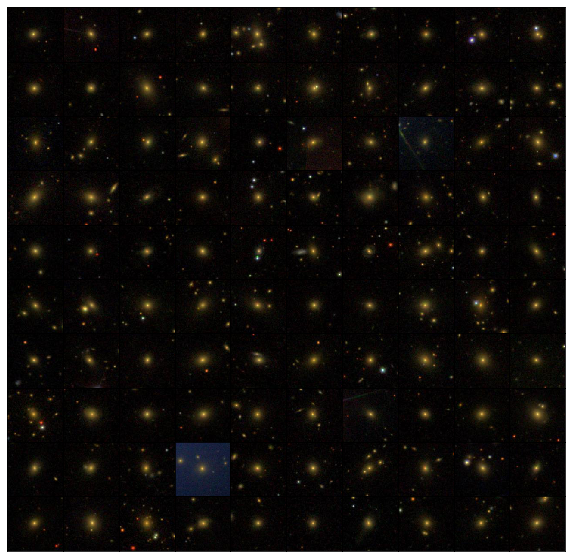

Ell 1


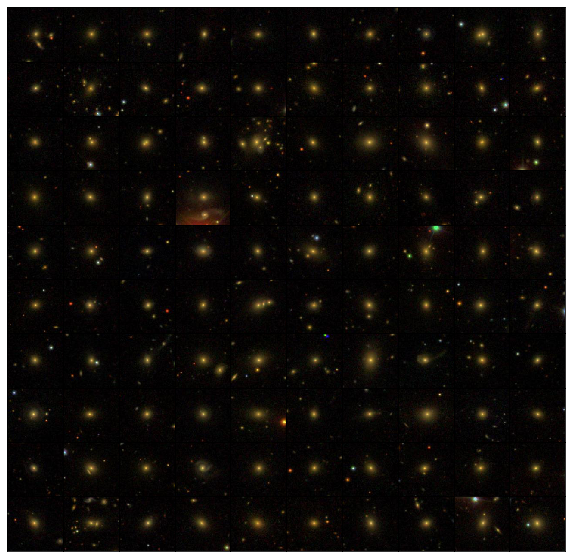

Ell 2


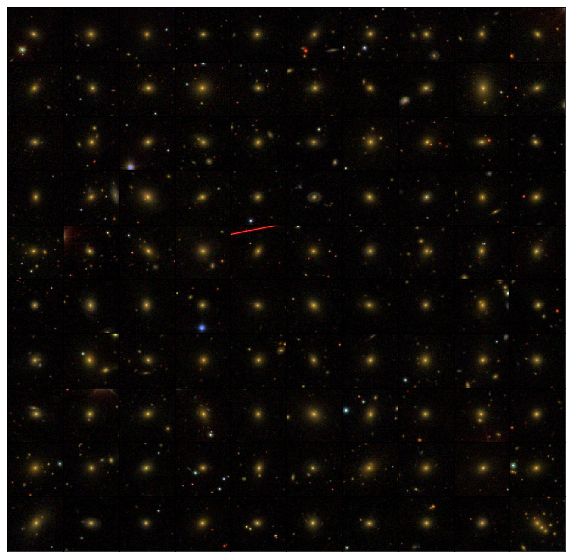

S0 0


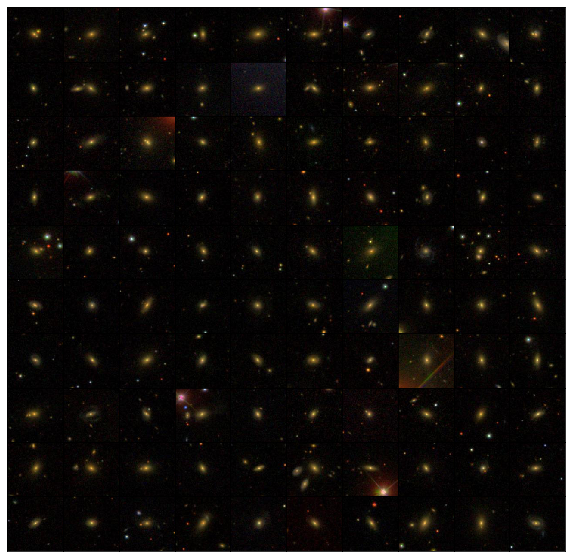

S0 1


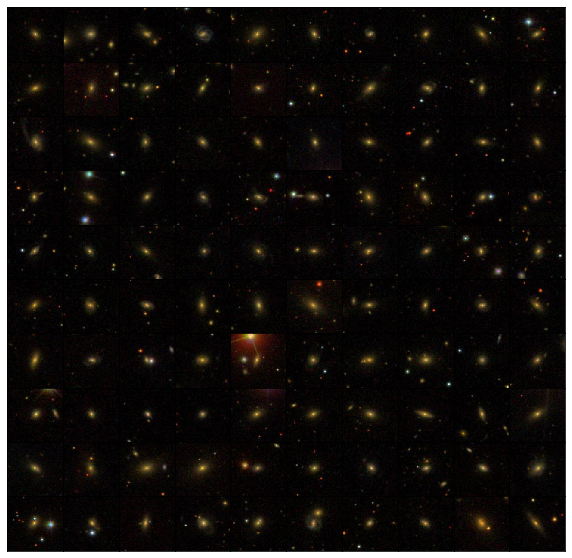

S0 2


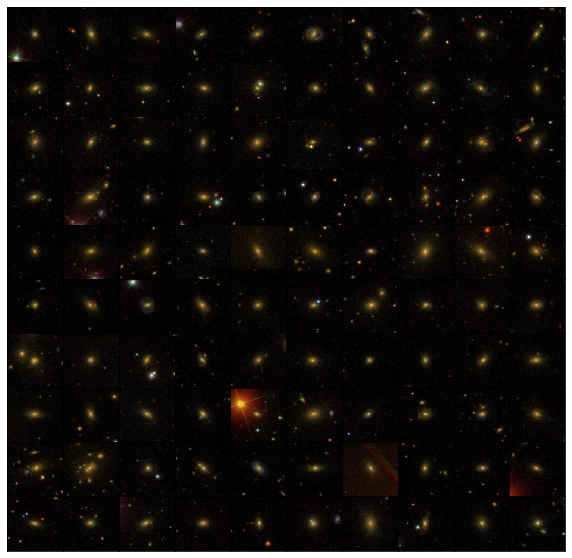

Sab 0


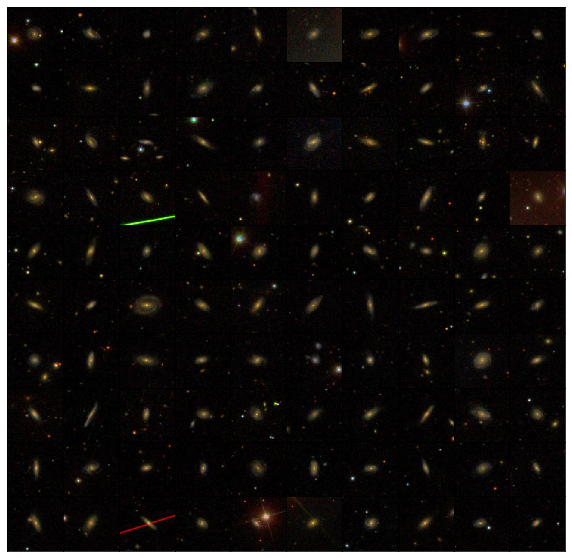

Sab 1


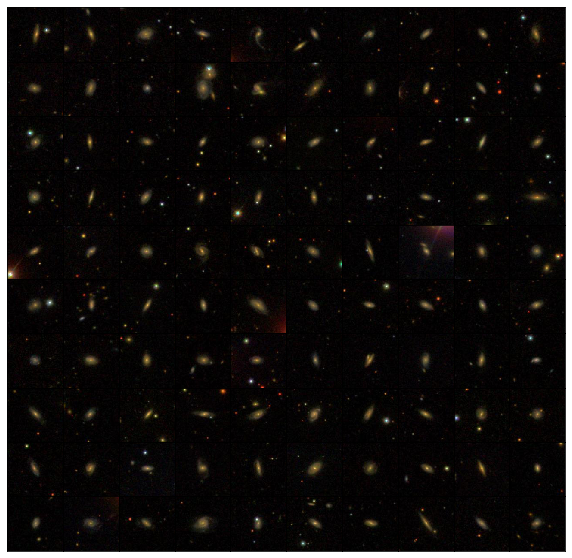

Sab 2


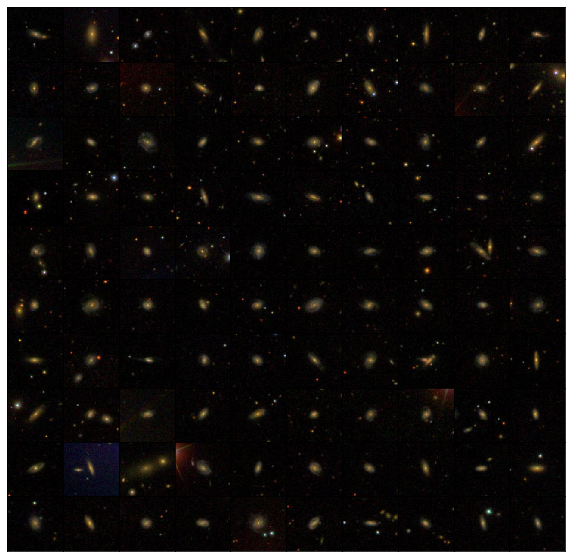

Scd 0


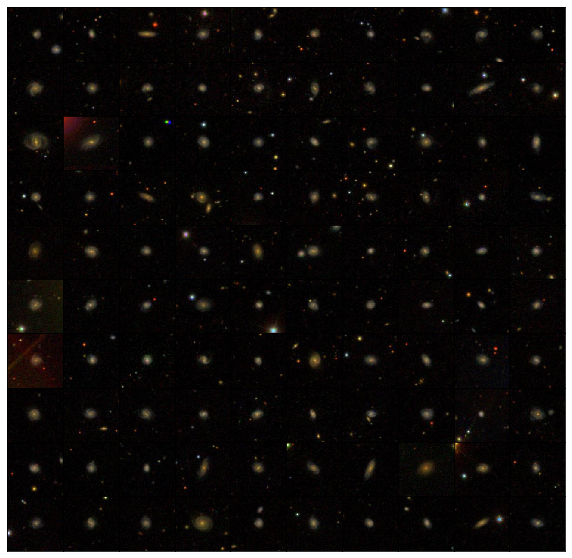

Scd 1


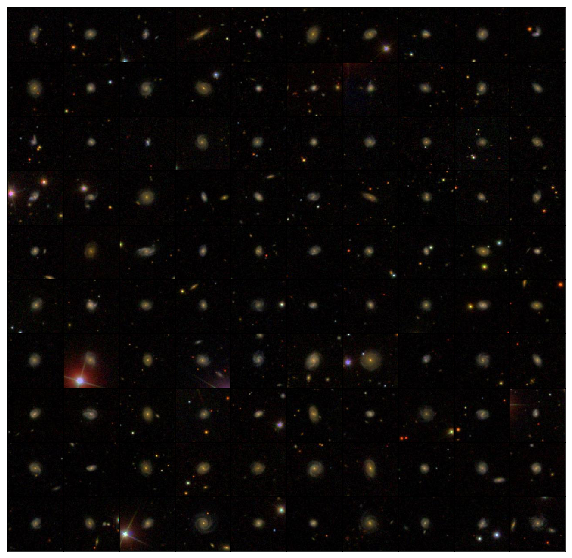

Scd 2


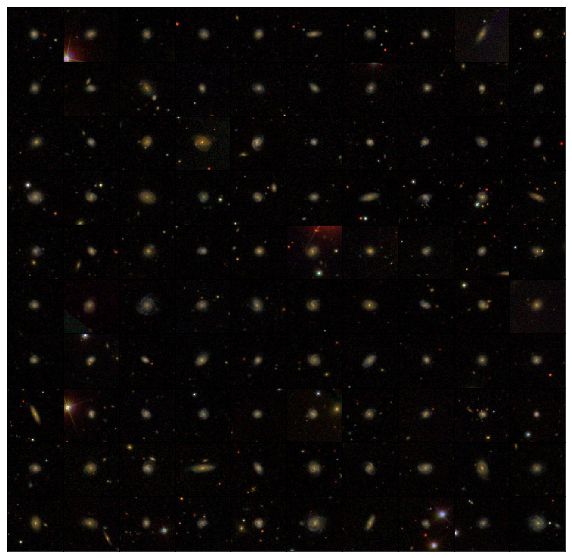

In [72]:
#from code.plot_utils import sdss_img_collage

# the number of rows and columns in the image gallery
nrow = 10; ncol = 10
# pixel size of the thumbnails to extract from the SDSS
npix = 130

# minimum and maximum luminosity distances for galaxy selection
Dmin = 500.; Dmax = 1000.; 
# absolute magnitude limit on the faint end
Mlim = -19.0
Pmorphlim = 0.6

# select galaxies with these distance and absolute magnitude limits
MDsel = (Mmeert < Mlim) & (d_Lm > Dmin) & (d_Lm < Dmax)
Ellp = (pEll>Pmorphlim) & (pEll>pS0) & (pEll>pSab) & (pEll>pScd) 
S0p  = ((pS0>Pmorphlim) & (pS0>pEll) & (pS0>pSab) & (pS0>pScd))
Sabp = ((pSab>Pmorphlim) & (pSab>pEll) & (pSab>pS0) & (pSab>pScd))
Scdp = ((pScd>Pmorphlim) &(pScd>pEll) & (pScd>pS0) & (pScd>pSab))
EllT = (T<=-3) # Ell
S0T  = (0.5 >= T) & (T > -3) # S0
SabT = (4 >= T) & (T > 0.5) # Sab
ScdT = T > 4

rdata = sdata[MDsel & Ellp]
for i in range(3):
    print("Ell %d"%i)
    display_random_galaxies(rdata, nrow=nrow, ncol=ncol, npix=npix, scale=0.5, savefig='fig/Ellp_M19_Dmin500_Dmax1000_%d.png'%i)

rdata = sdata[MDsel & S0p]
for i in range(3):
    print("S0 %d"%i)
    display_random_galaxies(rdata, nrow=nrow, ncol=ncol, npix=npix, scale=0.5, savefig='fig/S0p_M19_Dmin500_Dmax1000_%d.png'%i)

rdata = sdata[MDsel & Sabp]
for i in range(3):
    print("Sab %d"%i)
    display_random_galaxies(rdata, nrow=nrow, ncol=ncol, npix=npix, scale=0.5, savefig='fig/Sabp_M19_Dmin500_Dmax1000_%d.png'%i)

rdata = sdata[MDsel & Scdp]
for i in range(3):
    print("Scd %d"%i)
    display_random_galaxies(rdata, nrow=nrow, ncol=ncol, npix=npix, scale=0.5, savefig='fig/Scdp_M19_Dmin500_Dmax1000_%d.png'%i)
